In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import unicodedata
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('allegro-api-transactions.csv')

In [4]:
df.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


### Liczba unikalnych nazw miast
Zobaczymy, że miast w naszym zbiorze danych jest bardzo dużo będzie to powodowało problemy np. z One-Hot Encoding. Dlatego będę próbował jakoś ograniczyć liczbę tych rekordów. Sprawdzę czy rozróżniane są miasta z pisane wielkimi literami i małymi oraz z polskimi znakami i bez nich a następnie je zrzutuje.

In [5]:
from collections import Counter
loc = df.it_location
dfl = pd.DataFrame({"keys":Counter(loc).keys(), "val" :Counter(loc).values()})
#dfl.loc[dfl.val > 20]
len(dfl)

10056

In [6]:
dfl[dfl['keys'].isin(["WARSZAWA", "Warszawa", "warszawa", 'Wielun', 'Wieluń'])]

,keys,val
0,Warszawa,23244
83,WARSZAWA,2672
142,warszawa,1123
578,Wieluń,508
6765,Wielun,1


In [7]:
df['it_location'] = df['it_location'].apply(str.title)

In [8]:
def unicode(x):
    return unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')

In [9]:
tmp = df['it_location'].apply(unicode)
df["it_location"] = tmp

In [10]:
loc = df.it_location
dfl = pd.DataFrame({"keys":Counter(loc).keys(), "val" :Counter(loc).values()})
#dfl.loc[dfl.val > 20]
len(dfl)

7554

In [11]:
df_target = df.copy(deep=True)
df_onehot = df.copy(deep=True)

Udało nam się ograniczyć liczbę unikalnych nazw miast o ok. 2500. 
### Target Encoding
Zatem możemy próbować zakodować je przy pomocy metody Target Encoding.

Zaletą target encodingu jest możliwość zakodowania zmiennej która posiada bardzo dużo kategorii. 
Zmienna kategoryczna zamieniana jest na liczbę dzięki temu przyspieszają się obliczenia oraz dostajemy tylko jedną kolumnę co jest główną zaletą w porówaniu z One-Hot encoding.

Wadami są straty danych które następują przez takie rzutowanie, ponieważ zmienna jest zamieniana na średnią targetu dla danej kategorii a wiemy, że średnia jest wrażliwa na odchylenia. Tworzymy też nieistniejącą hierarchię w zmiennej. Przy małych zbiorach może się zdarzyć, że dwie kategorie zostaną rzutowane na taką samą wartość.

In [12]:
encoder = ce.TargetEncoder(cols=['it_location'])
encoder.fit(df_target, df_target.price)

TargetEncoder(cols=['it_location'])

In [13]:
df_target = encoder.transform(df_target)

In [14]:
encoder = ce.TargetEncoder()
df_target['it_location_encoded'] = encoder.fit_transform(df['it_location'], df['price'])

In [15]:
df_target.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,it_location_encoded
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,84.132898,Komputery,84.132898
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,84.132898,"Odzież, Obuwie, Dodatki",84.132898
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,64.883187,Dom i Ogród,64.883187
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,35.433365,Książki i Komiksy,35.433365
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,73.782872,"Odzież, Obuwie, Dodatki",73.782872


Udało nam się zakodować zmienną *it_location*

### One-Hot encoding *main_catagory*
Sprawdzam ile jest różnych wartości *main_category*. Jest ich 27 więc przy tak dużej ilości recordów możemy sobie pozwolić na zakodowanie ich wszystkich za pomocą one-hot. Przy okazji zamieniam nazwy nowo powstałych kolumn tak aby można było rozpoznać kategorię.

In [16]:
len(pd.unique(df_onehot['main_category']))

27

In [17]:
encoder = ce.OneHotEncoder(cols=['main_category'])
df_onehot = encoder.fit_transform(df_onehot)

In [18]:
df_onehot.columns.values[-27:] = "is_"+pd.unique(df['main_category'])

### CatBoost encoding

Podział kodowania polegający na permutacji danych, podziale zmiennej na podzbiory a następnie obliczaniu wartości na podstawie pozoastałych wartości.

In [19]:
encoder =ce.CatBoostEncoder(cols = ['main_category'])
df_cat = df.copy(deep=True)
df_cat = encoder.fit_transform(df_cat, df_cat.price)

In [20]:
df_cat['main_category']

0          76.811350
1          76.811350
2          76.811350
3          76.811350
4          40.855675
             ...    
420015    107.529199
420016     28.130777
420017     75.859354
420018     71.203460
420019    134.417590
Name: main_category, Length: 420020, dtype: float64

### Count Encoding

Proste kodowanie które zamienia zmienne kategoryczne na liczbę jej wystąpień w kolumnie. Daje to pewną intuicję co jest większe a co mniejsze. Natomiast może pojawić się problem, że różne labele zostaną zmapowane na tą samą liczbę jeśli wystąpią tyle samo razy.

In [21]:
df_count = df.copy(deep = True)

In [22]:
encoder = ce.CountEncoder(cols = ['main_category'])

In [23]:
df_count = encoder.fit_transform(df_count, df_count.price)

In [24]:
sum(np.unique(df_count['main_category']))

420020

## Wizualizacja

In [25]:
df_viz = pd.DataFrame({'cat':df_cat.main_category[:100]})
df_viz2 = pd.DataFrame({'cnt': df_count.main_category[:100]})
df_viz3 = df_onehot[:100]
df_viz2

,cnt
0,14491
1,54257
2,91042
3,11572
4,54257
...,...
95,14491
96,54257
97,54257
98,28096


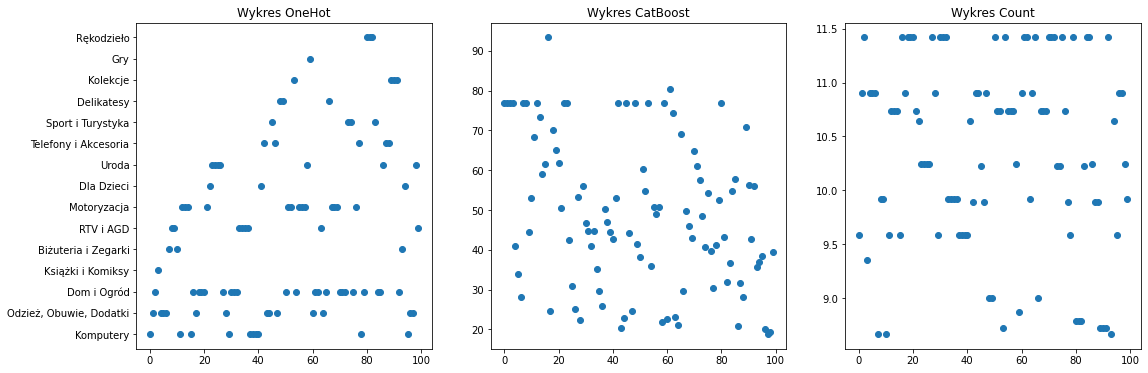

In [26]:

fig, axs = plt.subplots(1,3, figsize=(18,6))
axs[1].scatter(x=df_viz.index, y=df_viz.cat)
axs[2].scatter(x=df_viz2.index, y=np.log(df_viz2.cnt))
axs[0].scatter(x=df_viz3.index, y=df['main_category'][:100])
titles = ['OneHot', 'CatBoost', 'Count']
for i in range(0,3):
    axs[i].title.set_text('Wykres ' + titles[i])

## Uzupełnianie braków 

In [27]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
from sklearn.metrics import mean_squared_error

In [28]:
cols_n = ['price', 'it_seller_rating', 'it_quantity']
df_miss = df[cols_n].copy(deep=True)

In [29]:
ls_os = 10*[0]
amound = round(df.shape[0]/10)
for i in range(0,10):
    df_rate = df_miss.copy(deep=True)
    rand_index = np.random.choice(df_rate.index, amound, False)
    df_rate['it_seller_rating'][rand_index] = None

    imp = IterativeImputer(max_iter= 10, random_state= 0)
    imp.fit(df_rate.drop(rand_index))
    df_rate = imp.transform(df_rate)
    df_rate = pd.DataFrame(df_rate, columns=cols_n)

    ls_os[i] = np.sqrt(mean_squared_error(df_miss['it_seller_rating'][rand_index], df_rate['it_seller_rating'][rand_index]))

In [30]:
imp1 = np.std(ls_os)

In [31]:
ls_os

[36774.2956866823,
 36522.7129839732,
 37159.935546010165,
 36616.17337858048,
 36538.42097662444,
 36660.55290145212,
 37495.79844188589,
 36001.086688433694,
 37011.085642321035,
 36661.58487479926]

In [32]:
ls_os_r = 10*[0]
ls_os_q = 10*[0]
amound = round(df.shape[0]/10)
for i in range(0,10):
    df_rate = df_miss.copy(deep=True)
    rand_index1 = np.random.choice(df_rate.index, amound, False)
    rand_index2 = np.random.choice(df_rate.index, amound, False)
    df_rate['it_seller_rating'][rand_index1] = None
    df_rate['it_quantity'][rand_index2] = None

    imp = IterativeImputer(max_iter= 10, random_state= 0)
    imp.fit(df_rate.drop(rand_index))
    df_rate = imp.transform(df_rate)
    df_rate = pd.DataFrame(df_rate, columns=cols_n)

    ls_os_r[i] = np.sqrt(mean_squared_error(df_rate['it_seller_rating'][rand_index1], df_miss['it_seller_rating'][rand_index1]))
    ls_os_q[i] = np.sqrt(mean_squared_error(df_rate['it_quantity'][rand_index2], df_miss['it_quantity'][rand_index2]))

In [33]:
imp2 = np.std(ls_os_r)

## Wizualizacja błędu
Widać, że błąd imputacji zmiennej *it_seller_rating* nie zależał od tego czy brakowało również *it_quantity*. Jest to dość nieintuicyjne ponieważ można było podejrzewać, że barki w danych z innej kolumny będą pociągały za sobą większą rozbieżność danych imputowanych. Najwidzoczniej nasza metoda imputacji nie korzysta z innych kolumn.
Warto, też pamiętać, że przy braku danych w *it_quality* szum baraku danych w naszym ogólnym modelu będzie większy.

Odchylenie standardowe zmiennej it_selller_rating: 385.18849364949756
Imputacja braków zmiennych wspólnie: 
Odchylenie standardowe zmiennej it_selller_rating: 300.7340783588597
Odchylenie standardowe zmiennej it_selller_rating: 237.99758409663664


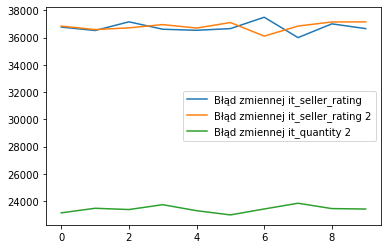

In [47]:

data =[ls_os, ls_os_r, ls_os_q]
sns.lineplot(data = ls_os, markers=True)
sns.lineplot(data = ls_os_r, markers=True, dashes=False)
sns.lineplot(data = ls_os_q, markers=True, dashes=False)
plt.legend(['Błąd zmiennej it_seller_rating','Błąd zmiennej it_seller_rating 2','Błąd zmiennej it_quantity 2'])

print('Odchylenie standardowe zmiennej it_selller_rating: ' + str(np.std(ls_os)))
print('Imputacja braków zmiennych wspólnie: ')
print('Odchylenie standardowe zmiennej it_selller_rating: ' + str(np.std(ls_os_r)))
print('Odchylenie standardowe zmiennej it_selller_rating: ' + str(np.std(ls_os_q)))